##### Reading in the data and importing

In [58]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('punkt')
nltk.download("stopwords")
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

tweets_df = pd.read_csv('data/TwitterDataset/Tweets.csv')


[nltk_data] Downloading package punkt to /home/22572201/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/22572201/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##### Viewing the data

In [59]:
tweets_df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


##### Viewing the distribution and the information of the data

In [60]:
# it is interesting to see that 50% is 1.0 and 75% is 1.0 as well for airline_sentiment_confidence.
tweets_df.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


#### Looking at data's NaN values and the Types of the data


In [61]:
# Similar missing data from airline_sentiment_gold and negativereason_gold
print(tweets_df.isna().sum())
tweets_df.info()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negative

##### Data visualization

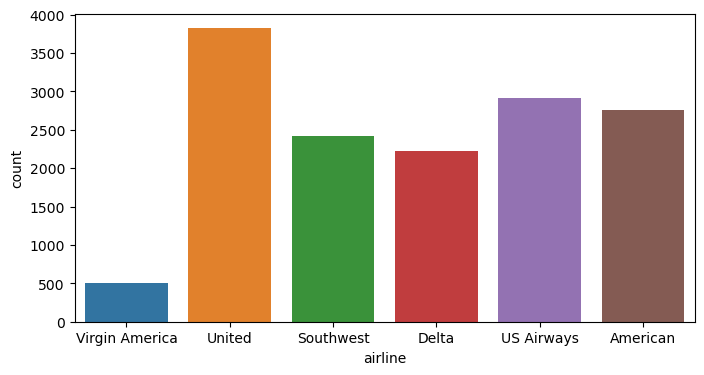

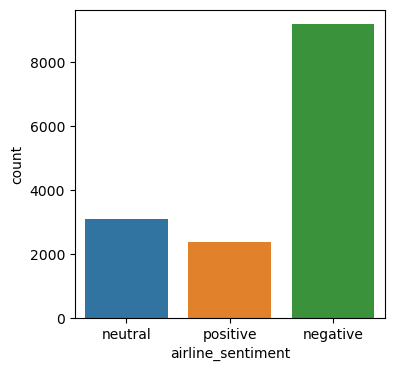

In [62]:
# Southwest, Delta, US Airways, and American aren the most similar in counts and United is the largest count while virgin America is the smallest.
plt.figure(figsize=(8, 4))
sns.countplot(x="airline", data = tweets_df)
plt.show()
# The most common sentiment is negative. Neutral and positive are similar .
plt.figure(figsize=(4, 4))
sns.countplot(x='airline_sentiment', data=tweets_df)
plt.show()

#### Data Cleaning

In [63]:
# Pre-processing inspiration from https://www.kaggle.com/code/nkitgupta/text-representations
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer 
from nltk.tokenize import RegexpTokenizer
# Commmon words list
stopwords = stopwords.words('english')
# Remove -ing words
stemmer = SnowballStemmer('english')
# Removing stopping words and stemming words for TFIDF tokenizer
def removePunctuationTFIDF(sentence, stem = False):
  sentence = [re.sub(r"@\w*", "", sentence)]
  text = []
  for word in sentence:
      if word not in stopwords:
        if stem:
          text.append(stemmer.stem(word))
        else:
          text.append(word.lower())
  text = re.sub("[^a-zA-Z1-9]", " ", " ".join(text)).split()
  return " ".join(text)

# Removing only `@` and the usernames mentioned, this is because bert is a contextual model.
def removePunctuationBert(sentence):
  sentence = [re.sub(r"@\w*", "", sentence)]
  return " ".join(sentence)

# Sentiment range inspiration from https://www.kaggle.com/code/fahadmehfoooz/sentiment-analysis-svm-nb-bagging-boosting-rf-lstm
# 1 = positive, 0 = neutral, -1 = negative
def sentimentRange(value):
  if value == 'positive':
    return 1
  elif value == 'negative' :
    return -1
  else :
    return 0



df = tweets_df
df['cleaned_tweet'] = df['text'].apply(removePunctuationTFIDF)
df['sentiment'] = df['airline_sentiment'].apply(sentimentRange)
df[["sentiment",'cleaned_tweet']]

,sentiment,cleaned_tweet
0,0,what said
1,1,plus you ve added commercials to the experienc...
2,0,i didn t today must mean i need to take anothe...
3,-1,it s really aggressive to blast obnoxious ente...
4,-1,and it s a really big bad thing about it
...,...,...
14635,1,thank you we got on a different flight to chicago
14636,-1,leaving over 2 minutes late flight no warnings...
14637,0,please bring american airlines to blackberry1
14638,-1,you have my money you change my flight and don...


#### Vectorizing the data
Options:
- TF-IDF
- Bert
- Word2Vec

https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794

##### TF-IDF

In [64]:
# Creating object of TF-IDF vectorizer
vectorizer = TfidfVectorizer(use_idf=True, lowercase=True)
X_tf_idf= vectorizer.fit_transform(df.cleaned_tweet)
x_train, x_test, y_train, y_test = train_test_split(X_tf_idf, df['airline_sentiment'], random_state=42)

In [65]:
#Using bert as a tokenizer
import transformers
tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)
naturalLanguageProcessing = transformers.DistilBertModel.from_pretrained('distilbert-base-uncased')
# X_test = tokenizer.tokenize(corpus=tweets_df["text"], tokenizer=tokenizer, max_len=128)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
